# Attempt to do some Bayesian forecasting

* Used the work done on:
    * https://towardsdatascience.com/forecasting-with-bayesian-dynamic-generalized-linear-models-in-python-865587fbaf90

In [1]:
import sys
sys.path.append("../")
from Hack import load
from Hack.rl import get_expected_price as get_ep
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pybats
from pybats.loss_functions import MAPE
from pybats.analysis import analysis
from pybats.point_forecast import median
from pybats.plot import plot_data_forecast

In [2]:
#Load the data
epex = load.epex().load()

In [4]:
forecast_start = 100
forecast_end = 1000
length=forecast_end-forecast_start
indexs=np.arange(forecast_start,forecast_end+1)
prices=epex['apx_da_hourly'].values
date_indexs = np.arange(np.size(prices))

mod, samples = analysis(Y = prices[1:], X=date_indexs[1:], family='poisson',
    forecast_start=forecast_start,      
    forecast_end=forecast_end,         
    k=1,
    ntrend=1,                   # Intercept and slope in model
    nsamps=5000,                # Number of samples taken in the Poisson process
    seasPeriods=[48],           # Length of the seasonal variations in the data - i.e. every 24hr here
    seasHarmComponents=[[1,2]], # To pick out the half dayly and daily harmonics
    prior_length=48,            # How many data points to use in defining prior - i.e. 48 = one day
    deltrend=0.94,              # Discount factor on the intercept parameter
    delregn=0.90,               # Discount factor on the regression parameters
    delVar=0.98,
    delSeas=0.98,
    rho=.6, # Random effect to increase variance
    )

forecast = median(samples)

# set confidence interval for in-sample forecast
credible_interval=66
alpha = (100-credible_interval)/2
upper=np.percentile(samples, [100-alpha], axis=0).reshape(-1)
lower=np.percentile(samples, [alpha], axis=0).reshape(-1)
print("MAPE:", MAPE(prices[-18:], forecast[-18:]).round(2))

beginning forecasting
MAPE: 83.06


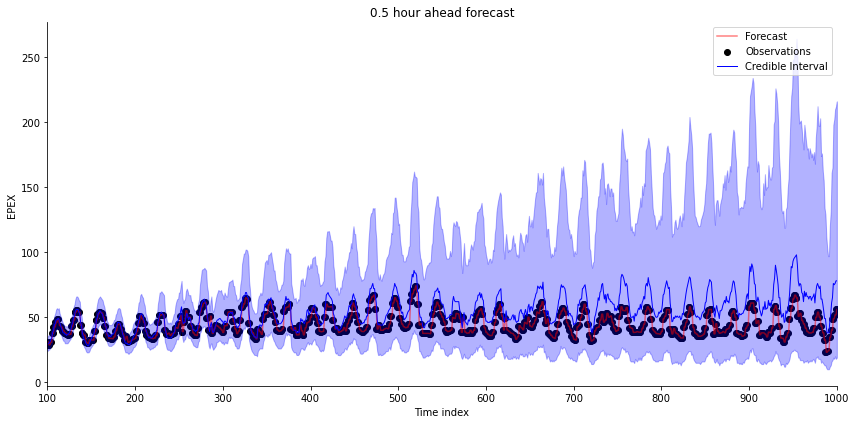

In [6]:
%matplotlib inline
from matplotlib import lines

# Plot the 1-quarter ahead forecast
h = 1
start = forecast_start + h
end = forecast_end + h + 1

fig, ax = plt.subplots(figsize=(12, 6))
#line1 = ax.plot(date_indexs[start:end],prices[start:end],label='Data',color='r')
ax.plot(date_indexs[start:end],prices[start:end],label='Data',color='r',alpha=0.5)
plot_data_forecast(fig, ax, y = prices[start:end],
    samples = samples[:,:,h-1],
    f = forecast[:,h-1],
    dates = indexs,
    xlabel='Time index', ylabel='EPEX', title='0.5 hour ahead forecast',credible_interval=50)
##handles, labels = ax.get_legend_handles_labels()
#handles.append(line1)
#labels.append("Data")

plt.show()